In [2]:
import numpy as np
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
#%matplotlib notebook
from multiprocessing import Pool
from tqdm import tqdm
import time
#from pandarallel import pandarallel
model = load_model('i_predict CD_segment')

In [3]:
sc = StandardScaler()

In [18]:
df1_std = pd.read_csv('CD3D_110℃_segment_std', usecols=[1,2,3,4,5,6])

In [19]:
df_a = df1_std.head()
df_a

,x座標,y座標,z座標,V[V],Segment,i[A/m^2]
0,-0.191417,-0.582991,0.931613,-1.415906,-1.215323,1.529400
1,-0.114882,-0.582991,0.931613,-1.415906,-1.215323,1.529463
2,-1.492519,-0.582991,0.310611,-1.415906,-1.215323,1.527983
3,-1.492519,-0.567687,0.310611,-1.415906,-1.215323,1.527918
4,-1.492519,-0.567687,0.517611,-1.415906,-1.215323,1.527902


In [20]:
df1 = pd.read_csv('CD3D_110℃_segment', usecols=[1,2,3,4,5,6])

In [10]:
def Vstd(V):
 #説明変数Vの平均と標準偏差を出し、求めたいVの値を標準化する。
 global df1
 df_V = pd.DataFrame([0.25,0.275,0.3,0.325,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0])
 V_std = (V-df1["V[V]"].mean())/df1["V[V]"].std()
 return(V_std)


def Segmentstd(segment):
  #説明変数segmentの平均と標準偏差を出し、求めたいsegmentの値を標準化する。
 global df1
 df_segment = pd.DataFrame([0.7,1.4,2.1])
 segment_std = (segment-df1["Segment"].mean())/df1["Segment"].std()
 return(segment_std) 

In [46]:
#指定した変数の電流密度分布予測を求める
def I_pre0(V,segment):
 eps = 10**(-6)

 global df1, df1_std
 df2_std = df1_std[(Vstd(0.4)-eps < df1_std['V[V]']) &  ( df1_std['V[V]'] < Vstd(0.4)+eps )] #Segmentを固定して座標を抽出  & (Segmentstd(segment)-eps < df1_std['Segment']) & (df1_std['Segment'] < Segmentstd(segment)+eps)
 df3_std = df2_std.drop(['V[V]','Segment','i[A/m^2]'], axis=1)
 df2_std2 = pd.DataFrame({'V[V]':[Vstd(V)],'Segment':[Segmentstd(segment)]}, index=df2_std.index)  # *140798はSegmentごとのデータ数 
 df3_std2 = pd.concat([df3_std, df2_std2], axis=1)   #,df2_std2.drop(columns=['Segment'])
 df4_std = model.predict(df3_std2)    #モデルで予測
 df_iPRE1 = pd.DataFrame(df4_std)
 #df_iPRE1 =df4_std.apply(i_restd)   #予測値の標準化を戻す。（データフレームに関数を適用）
 df_iPRE2 = df_iPRE1.rename(columns={0:'i[A/m^2]'})
 df_iPRE2 = df_iPRE2.set_index(df2_std.index)
 df_iPRE = pd.concat([df2_std2,df_iPRE2], axis = 1)
 df_iPRE

 return df_iPRE

In [28]:
def i_COM(V,segment):  #COMSOLの結果を表示する関数
  global df1
  df_A = df1[(df1['V[V]']==V) & (df1['Segment']==segment)]
  #COMSOLの結果の正規化されてないグラフ
  fig2 = plt.figure(figsize=(12, 8))
  ax2 = fig2.add_subplot(111, projection='3d')

  sc2 = ax2.scatter(df_A['x座標'], df_A['y座標'],df_A['z座標'], c=df_A['i[A/m^2]'], cmap='jet', alpha=0.8)
  plt.colorbar(sc2)

  ax2.set_title(["COMSOL:"+str(V)+"V"], fontsize=20)   #+",Segment:"+str(segment)
  ax2.set_box_aspect((1,3,1))
  ax2.axes.xaxis.set_ticklabels([])
  ax2.axes.yaxis.set_ticklabels([])
  ax2.axes.zaxis.set_ticklabels([])
  ax2.set_box_aspect((1,3,1))

  ax2.set_xlim(-0.0005,0.001)
  #ax2.set_ylim(0,0.015)
  ax2.set_zlim(0,0.001)

  #plt.savefig('PEM_CD_COMSOL.png')
  plt.show()

In [48]:
def I_pre(V,segment):
  df_iPRE = I_pre0(V,segment)
  df_d = df1[(df1['V[V]']==0.4)]  

  fig5 = plt.figure(figsize=(12, 8))
  ax5 = fig5.add_subplot(111, projection='3d')

  sc5 = ax5.scatter(df_d['x座標'], df_d['y座標'], df_d['z座標'],c=df_iPRE['i[A/m^2]'],  cmap='jet', alpha=0.8)
  plt.colorbar(sc5)

  ax5.set_title(["ML"+str(V)+"V,Segment:"+str(segment)], fontsize=20)
  ax5.set_box_aspect((1,3,1))
  ax5.axes.xaxis.set_ticklabels([])
  ax5.axes.yaxis.set_ticklabels([])
  ax5.axes.zaxis.set_ticklabels([])

  ax5.set_xlim(-0.0005,0.001)
  ax5.set_zlim(0,0.001)
  #plt.savefig('PEM_CD_Predict_0.42V.png')
  plt.show()

In [45]:
eps = 10**(-6)

df2_std = df1_std[(Vstd(0.4)-eps < df1_std['V[V]']) &  ( df1_std['V[V]'] < Vstd(0.4)+eps )]                   #Segmentを固定して座標を抽出& (Segmentstd(0.7)-eps < df1_std['Segment']) & (df1_std['Segment'] < Segmentstd(0.7)+eps)
df3_std = df2_std.drop(['V[V]','Segment','i[A/m^2]'], axis=1)
df2_std2 = pd.DataFrame({'V[V]':[Vstd(0.4)],'Segment':[Segmentstd(0.7)]}, index=df2_std.index)  # *140798はSegmentごとのデータ数
df3_std2 = pd.concat([df3_std, df2_std2], axis=1)   #,df2_std2.drop(columns=['Segment'])
df4_std = model.predict(df3_std2)    #モデルで予測
df_iPRE1 = pd.DataFrame(df4_std)

605/605 [==============================] - 1s 1ms/step


In [41]:
df2_std

,x座標,y座標,z座標,V[V],Segment,i[A/m^2]
47418,-0.191417,-0.582991,0.931613,-0.792785,-1.215323,0.801771
47419,-0.114882,-0.582991,0.931613,-0.792785,-1.215323,0.801797
47420,-1.492519,-0.582991,0.310611,-0.792785,-1.215323,0.801305
47421,-1.492519,-0.567687,0.310611,-0.792785,-1.215323,0.801252
47422,-1.492519,-0.567687,0.517611,-0.792785,-1.215323,0.801244
...,...,...,...,...,...,...
335456,-0.114882,-1.700217,7.141632,-0.792785,1.240722,-1.296072
335457,0.114725,-1.700217,3.001619,-0.792785,1.240722,0.095312
335458,-0.344488,-1.700217,7.141632,-0.792785,1.240722,-1.279640
335459,0.114725,-1.700217,5.071625,-0.792785,1.240722,-0.782127


605/605 [==============================] - 1s 1ms/step


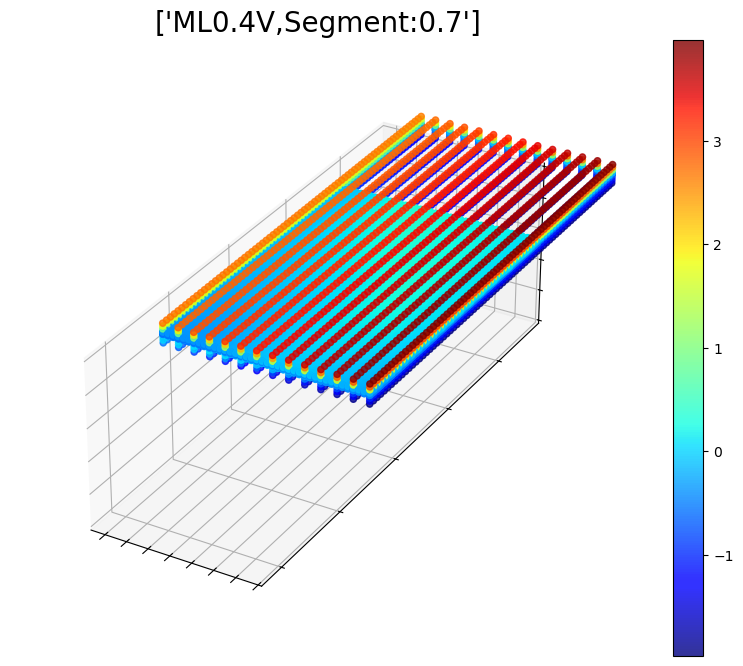

計算にかかった時間: 1.5058643817901611秒


In [49]:
start_time = time.time()
I_pre(0.4,0.7)
end_time = time.time()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

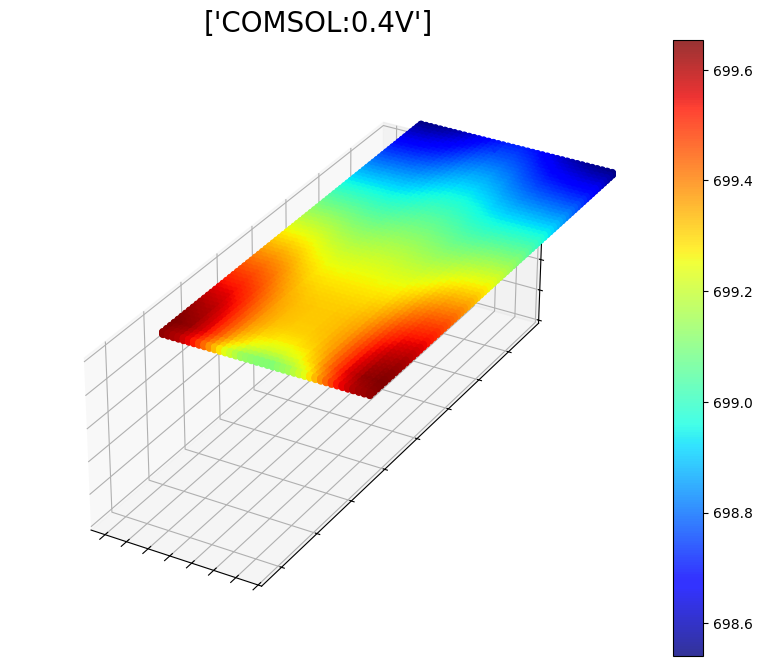

In [30]:
i_COM(0.4,0.7)

938/938 [==============================] - 2s 2ms/step


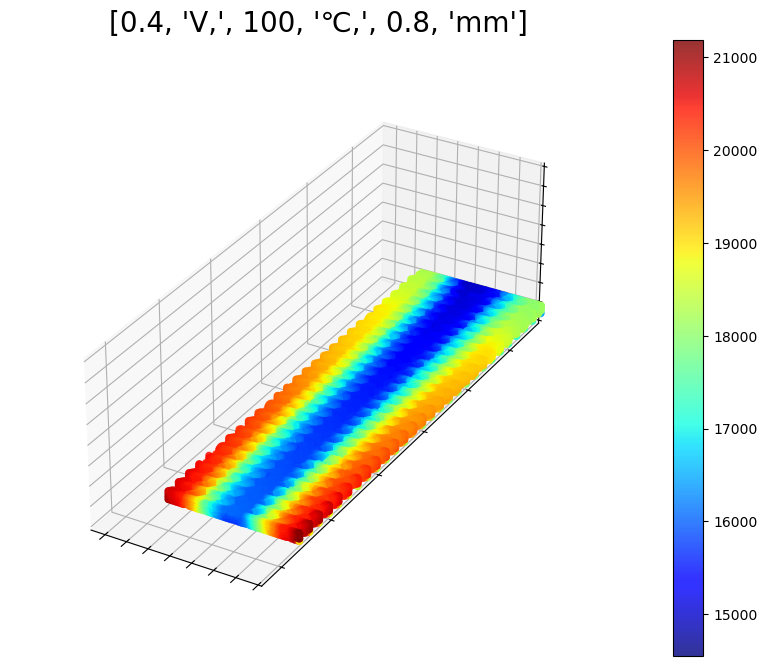

In [10]:
I_pre(0.4,100,0.8)

938/938 [==============================] - 3s 3ms/step


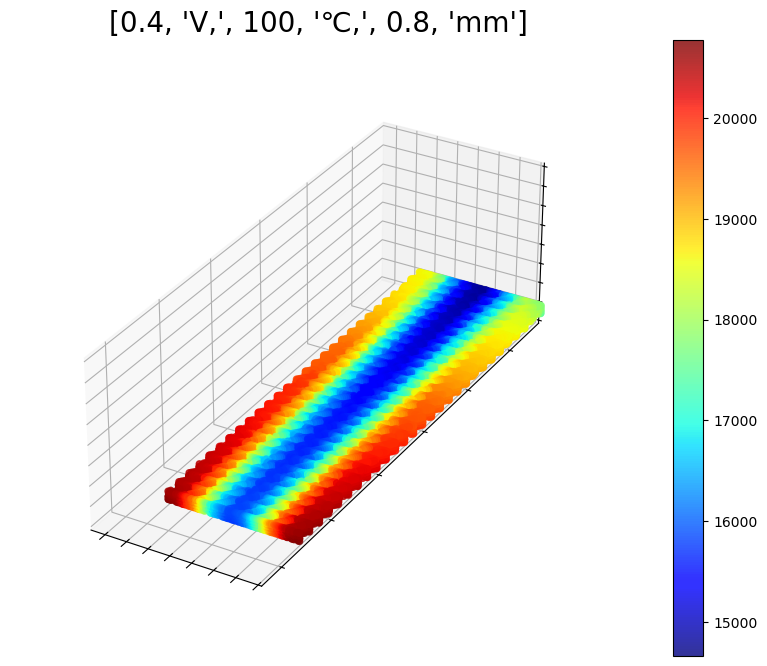

In [74]:
I_pre(0.4,100,0.8)

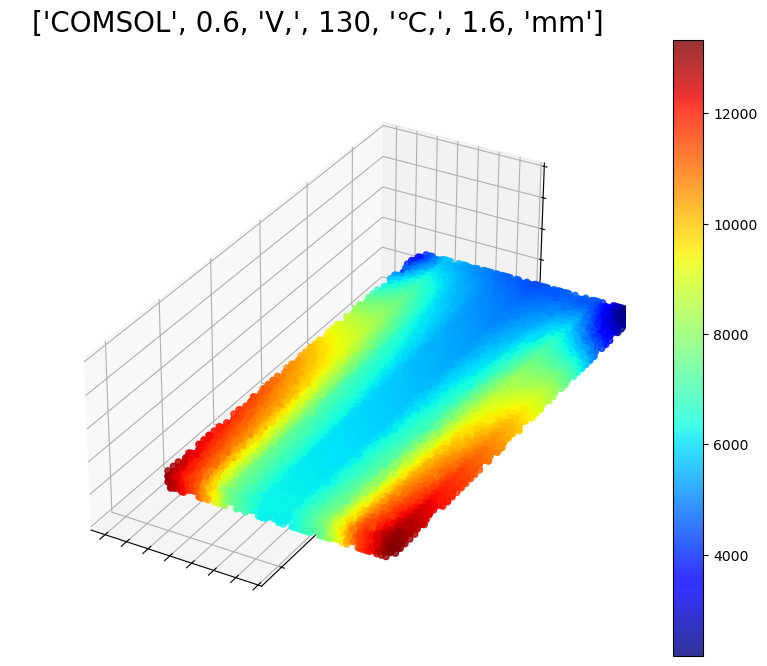

In [26]:
i_COM(0.6,130,1.6)

938/938 [==============================] - 2s 2ms/step


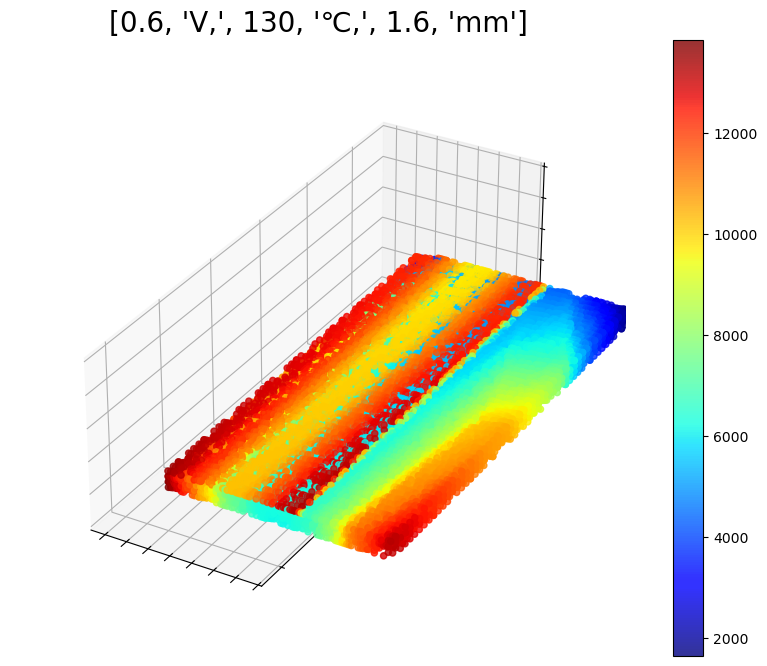

In [27]:
I_pre(0.6,130,1.6)

In [12]:
#COMSOLの結果の電流密度の平均を求める関数
def I_ave(V,T,W):
    global df1
    dfA = df1[(df1['V']==0.4) & (df1['T']==100)&(df1['W']==0.4)]
    dfB = dfA.replace({'V': {0.4: V}}).replace({'T': {100: T}}).replace({'W': {0.4: W}})
    dfC = model.predict(dfB.iloc[:,1:7])
    dfD = dfC.mean()
    print(dfD)

In [13]:
#COMSOLの電流密度の平均表示
dfCOM = pd.DataFrame(columns=['V[V]','T_cell[℃]','W_ch[mm]','i_ave[A/m^2]'])

def I_aveCOM(V,T,W):
  global df1
  df_iaveCOM1= df1[(df1['V[V]']==V) & (df1['T_cell[℃]']==T)&(df1['W_ch[mm]']==W)]
  df_iaveCOM2 = df_iaveCOM1['i[A/m^2]'].mean()
  return (df_iaveCOM2)

for V in [0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]:
  for T in [100,110,120,130,140,150]:
        for W in [0.4,0.8,1.6]:
          i_ave = I_aveCOM(V,T,W)
          new_row = {'V[V]':V,'T_cell[℃]':T,'W_ch[mm]':W,'i_ave[A/m^2]':i_ave}
          dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)
dfCOM

C:\Users\aruhy\AppData\Local\Temp\ipykernel_9884\1827688777.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCOM = pd.concat([dfCOM, pd.DataFrame([new_row])], ignore_index=True)


,V[V],T_cell[℃],W_ch[mm],i_ave[A/m^2]
0,0.4,100,0.4,19911.791366
1,0.4,100,0.8,17622.797661
2,0.4,100,1.6,8031.357182
3,0.4,110,0.4,21399.216778
4,0.4,110,0.8,18897.662070
...,...,...,...,...
193,0.9,140,0.8,1399.622068
194,0.9,140,1.6,1188.742602
195,0.9,150,0.4,2148.567194
196,0.9,150,0.8,2034.183265


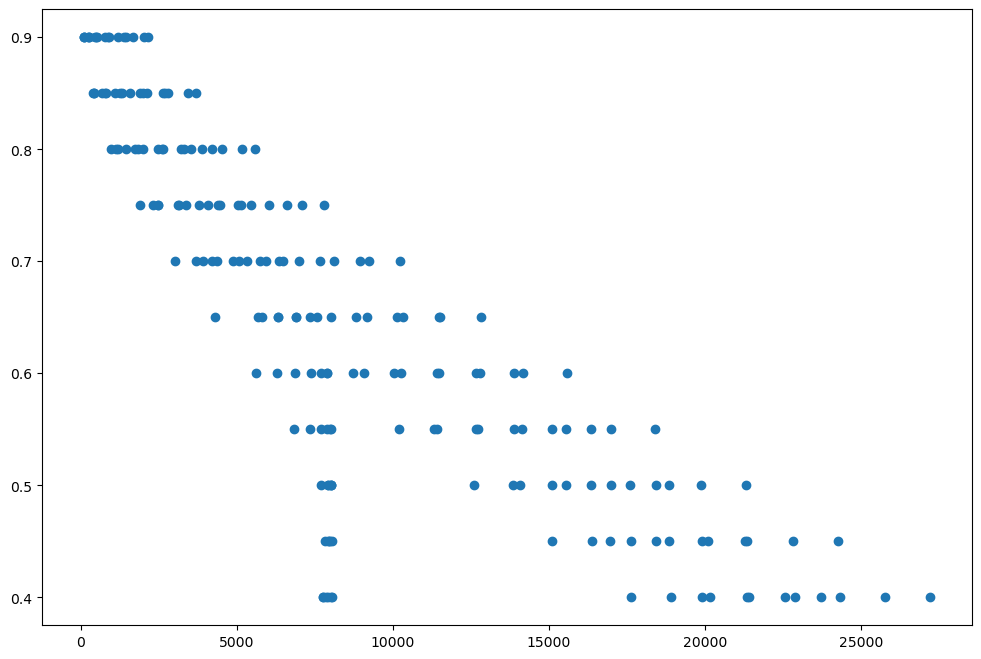

In [14]:
figCOM = plt.figure(figsize=(12, 8))

axCOM = figCOM.add_subplot(111)
scCOM = axCOM.scatter(dfCOM['i_ave[A/m^2]'],dfCOM['V[V]'])

plt.show()

In [18]:
def I_ave_pre(T,W):
 dfPRE = pd.DataFrame(columns=['V[V]','i_ave[A/m^2]'])
 
 global df1, df1_std
 df2_std = df1_std[['x座標','y座標','z座標']].head(30000) #これは0.4mmにしか使えない
 df3_std = pd.DataFrame({'T_cell[℃]':[Tstd(T)]*30000,'W_ch[mm]':[Wstd(W)]*30000})
 df4_std = pd.concat([df2_std,df3_std], axis=1)
 for V in np.linspace(0.4,0.9,100):   #Vの連続値に対応した電流密度を出す
    df5_std = pd.DataFrame({'V[V]':[Vstd(V)]*30000})
    df6_std = pd.concat([df4_std.iloc[:, :3],df5_std,df4_std.iloc[:,3:]], axis=1)
    df7_std = model.predict(df6_std.drop(columns=['W_ch[mm]']))   #モデルで予測
    df7_std = pd.DataFrame(df7_std)
    df7 = df7_std.apply(i_restd) #予測値の標準化を戻す。（データフレームに関数を適用）
    i_ave_pre = df7_std.mean()        #平均値を返す
    new_row = {'V[V]':V,'i_ave[A/m^2]':i_ave_pre}
    dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力
 
 return dfPRE

  1/938 [..............................] - ETA: 29s

C:\Users\aruhy\AppData\Local\Temp\ipykernel_9884\3686714403.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


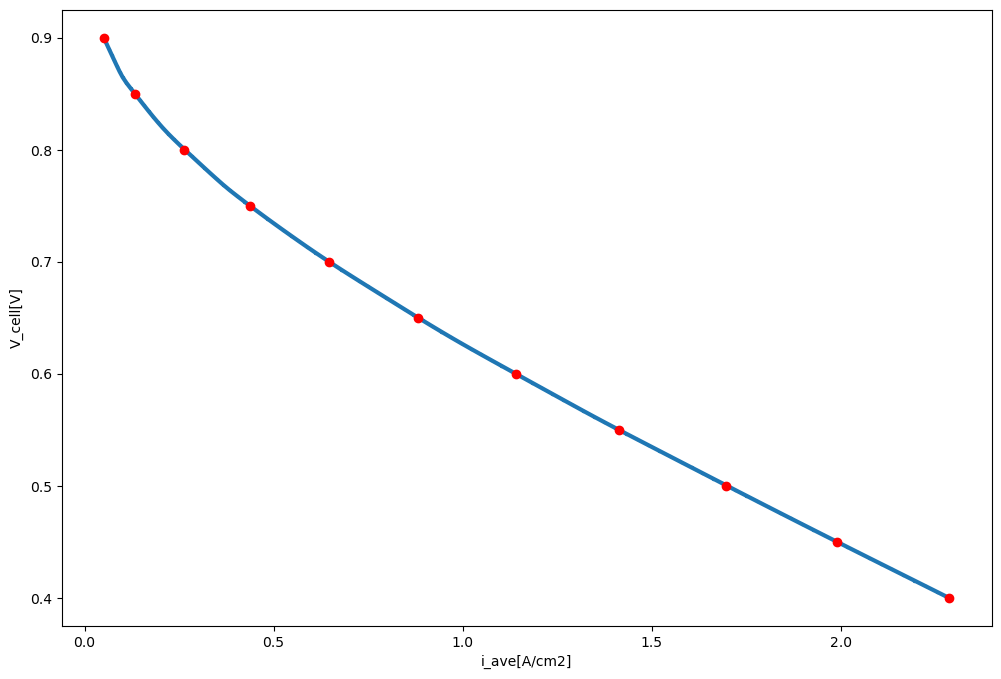

計算にかかった時間: -237.3811333179474秒


In [19]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(120,0.4)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==120)&(dfCOM["W_ch[mm]"]==0.4)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = end_time - start_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 33/938 [>.............................] - ETA: 1s 

C:\Users\aruhy\AppData\Local\Temp\ipykernel_16296\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


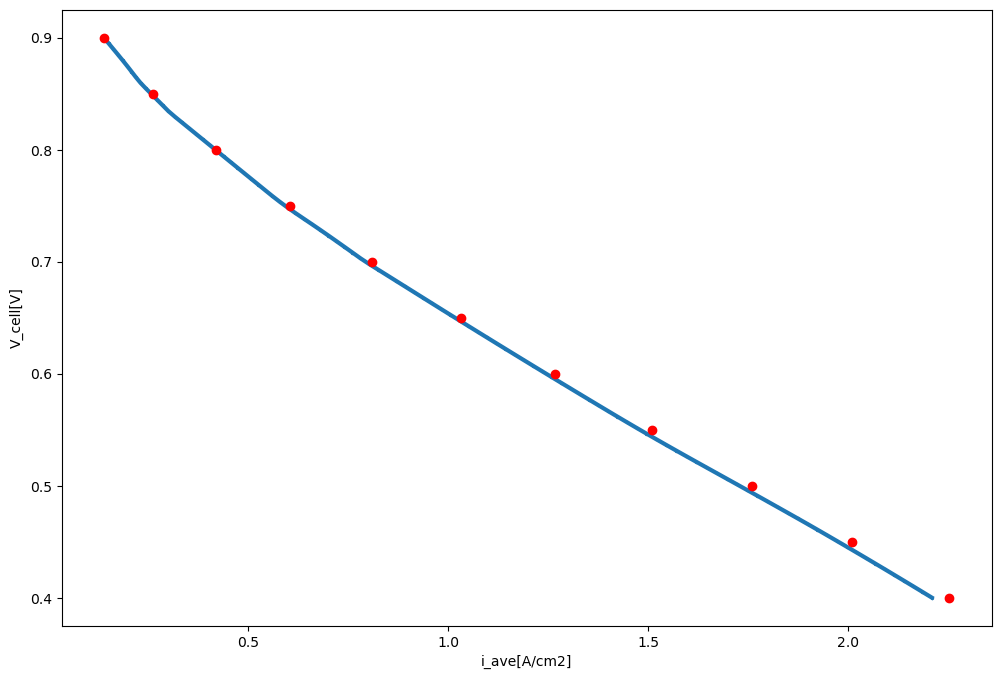

計算にかかった時間: 1827.3205797672272秒


In [44]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(140,0.8)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==140)&(dfCOM["W_ch[mm]"]==0.8)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 25/938 [..............................] - ETA: 1s 

C:\Users\aruhy\AppData\Local\Temp\ipykernel_9884\3686714403.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


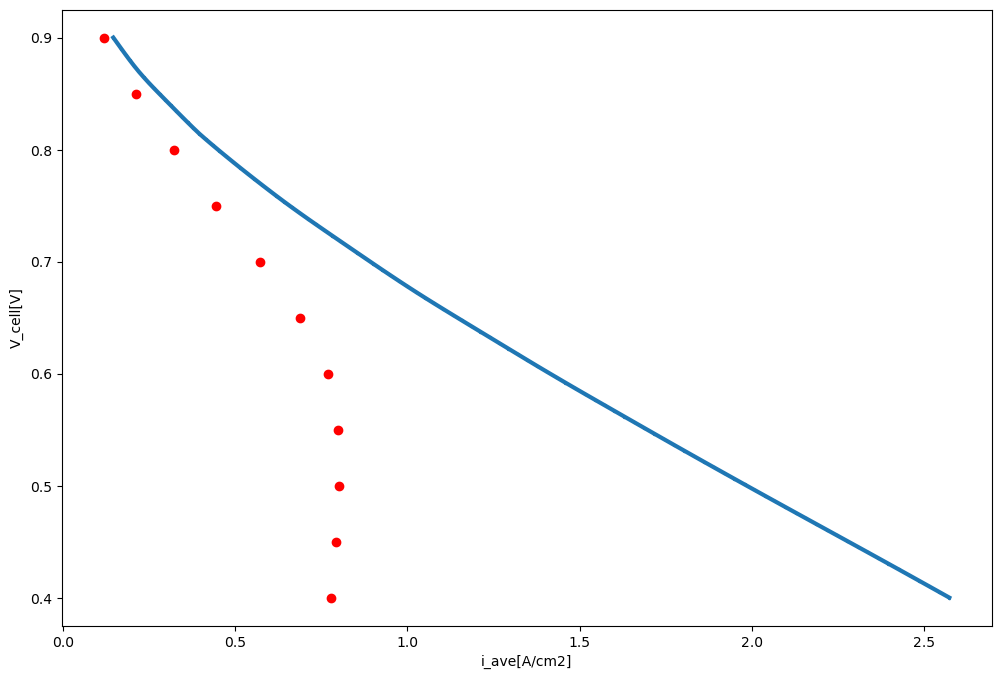

計算にかかった時間: 156.7197732925415秒


In [28]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(140,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==140)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 33/938 [>.............................] - ETA: 1s 

C:\Users\aruhy\AppData\Local\Temp\ipykernel_16296\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


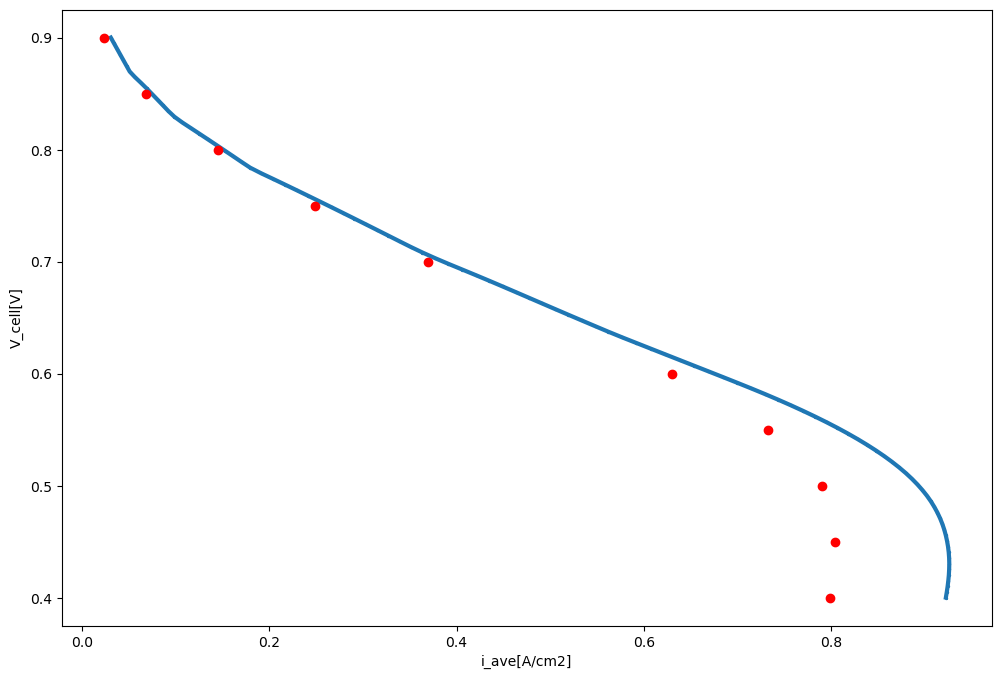

計算にかかった時間: 2345.898108482361秒


In [46]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(110,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==110)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

 29/938 [..............................] - ETA: 1s 

C:\Users\aruhy\AppData\Local\Temp\ipykernel_16296\2159109868.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfPRE = pd.concat([dfPRE, pd.DataFrame([new_row])], ignore_index=True) #データフレームとして予測値を出力


938/938 [==============================] - 2s 2ms/step


c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\collections.py:194: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  offsets = np.asanyarray(offsets, float)
c:\Users\aruhy\anaconda3\envs\MLMO\lib\site-packages\matplotlib\cbook.py:1345: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


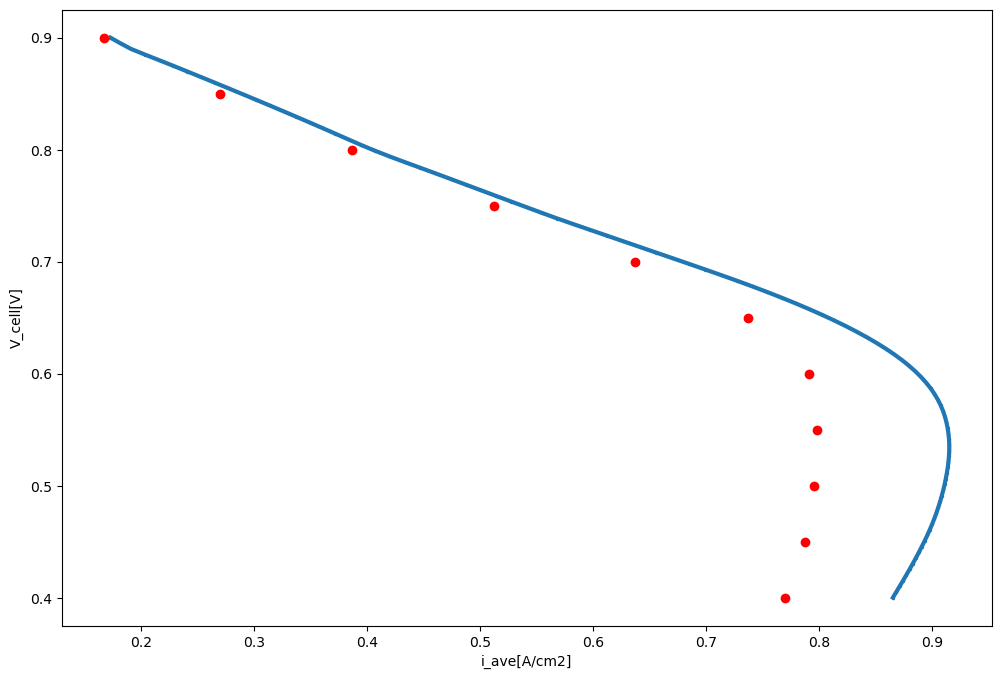

計算にかかった時間: 2889.0780849456787秒


In [48]:
start_time = time.time()

#予測結果の電流密度の平均表示
dfPRE =I_ave_pre(150,1.6)
figPRE = plt.figure(figsize=(12, 8))
axPRE = figPRE.add_subplot(111)

#CONSOL結果の表示
dfCOM0 = dfCOM[(dfCOM["T_cell[℃]"]==150)&(dfCOM["W_ch[mm]"]==1.6)]
scCOM0 = axPRE.scatter(dfCOM0['i_ave[A/m^2]']*1e-4,dfCOM0['V[V]'],color='red')

scPRE = axPRE.scatter(dfPRE['i_ave[A/m^2]']*1e-4,dfPRE['V[V]'],s=2,zorder=0)
axPRE.plot(dfPRE['i_ave[A/m^2]']*1e-4, dfPRE['V[V]'], linestyle='-', linewidth=3, zorder=0) 

# 軸ラベルを追加
plt.xlabel('i_ave[A/cm2]')
plt.ylabel('V_cell[V]')

plt.show()
elapsed_time = start_time - end_time   #経過時間を計算して表示
print(f"計算にかかった時間: {elapsed_time}秒")

In [29]:
import tensorflow as tf
# MAPEを計算する関数を定義
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10  # ゼロで割ることを避けるための小さな値
    percentage_error = tf.abs((y_true - y_pred) / tf.abs(y_true))
    mape = tf.reduce_mean(percentage_error) * 100.0
    return mape

In [32]:
df7 = model.predict(df1_std.drop(['W_ch[mm]'], axis=1).drop(['i[A/m^2]'], axis=1)) 

183750/183750 [==============================] - 459s 2ms/step


In [33]:
# MAPEを計算
df7 = pd.DataFrame(df7)
df8 = pd.concat([pd.DataFrame(df1['i[A/m^2]']),df7], axis=1)
#df9 = df8.sample(n=360000)
y_true = tf.constant(df8.iloc[:, 0].values, dtype=tf.float32)
y_pred = tf.constant(df8.iloc[:, 1].values, dtype=tf.float32)
mape_value = mean_absolute_percentage_error(y_true,y_pred)

# 結果を表示
print(f"MAPE:{mape_value.numpy()}%")

MAPE:11.02497673034668%


In [58]:
# R2を計算する関数
def r2_score(y_true, y_pred):
    total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    r_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
    return r_squared

In [59]:
# R2を計算
r2_value = r2_score(y_true, y_pred)

# 結果を表示
print(f"R2: {r2_value.numpy()}")

R2: 0.9996932148933411


In [52]:
pd.DataFrame(y_pred-y_true).max()

0    4616.430664
dtype: float32

In [53]:
pd.DataFrame(y_pred-y_true).idxmax()

0    5596197
dtype: int64

In [54]:
df8

,i[A/m^2],0
0,17102.504972,17080.279297
1,17057.706071,17074.972656
2,16512.382219,16569.097656
3,16763.835281,16791.601562
4,17054.110663,17031.292969
...,...,...
5879995,1933.844843,1886.677856
5879996,1491.955475,1494.572144
5879997,1423.258649,1434.218140
5879998,1429.083116,1439.890747


In [55]:
df1.iloc[1778067]

x座標             0.001450
y座標             0.009062
z座標             0.000317
V[V]            0.600000
T_cell[℃]     110.000000
W_ch[mm]        1.600000
i[A/m^2]     4946.599921
Name: 1778067, dtype: float64

In [56]:
df8.iloc[1778067]

i[A/m^2]    4946.599921
0           5164.592285
Name: 1778067, dtype: float64

In [57]:
tf.keras.metrics.mean_squared_error(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=14356.785>